<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Set-up" data-toc-modified-id="Set-up-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Set-up</a></span></li><li><span><a href="#Load-dataset" data-toc-modified-id="Load-dataset-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Load dataset</a></span></li><li><span><a href="#Preprocess-data" data-toc-modified-id="Preprocess-data-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Preprocess data</a></span><ul class="toc-item"><li><span><a href="#Sequence-input" data-toc-modified-id="Sequence-input-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Sequence input</a></span></li><li><span><a href="#Target-variables" data-toc-modified-id="Target-variables-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Target variables</a></span></li></ul></li><li><span><a href="#Data-exploration" data-toc-modified-id="Data-exploration-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Data exploration</a></span><ul class="toc-item"><li><span><a href="#Sequence-lengths" data-toc-modified-id="Sequence-lengths-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Sequence lengths</a></span></li><li><span><a href="#Biological-replicate-concordance" data-toc-modified-id="Biological-replicate-concordance-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Biological replicate concordance</a></span></li><li><span><a href="#Frequencies-of-nucleotides-at-each-position" data-toc-modified-id="Frequencies-of-nucleotides-at-each-position-4.3"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>Frequencies of nucleotides at each position</a></span></li><li><span><a href="#Target-RPM-distribution" data-toc-modified-id="Target-RPM-distribution-4.4"><span class="toc-item-num">4.4&nbsp;&nbsp;</span>Target RPM distribution</a></span></li></ul></li><li><span><a href="#Build-model" data-toc-modified-id="Build-model-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Build model</a></span></li><li><span><a href="#Train-model" data-toc-modified-id="Train-model-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Train model</a></span><ul class="toc-item"><li><span><a href="#Split-data-into-train,-val-and-test-sets" data-toc-modified-id="Split-data-into-train,-val-and-test-sets-6.1"><span class="toc-item-num">6.1&nbsp;&nbsp;</span>Split data into train, val and test sets</a></span></li></ul></li><li><span><a href="#Evaluate-model" data-toc-modified-id="Evaluate-model-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Evaluate model</a></span></li><li><span><a href="#Model-interpretation" data-toc-modified-id="Model-interpretation-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Model interpretation</a></span></li><li><span><a href="#References" data-toc-modified-id="References-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>References</a></span></li></ul></div>

# Set-up

In [1]:
# Classics
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Autoreload extension
if 'autoreload' not in get_ipython().extension_manager.loaded:
    %load_ext autoreload
    
%autoreload 2

In [2]:
# Check for GPU
import torch

print("Using a GPU? {}".format(torch.cuda.is_available()))
print("Device number [0-7]: {}".format(torch.cuda.current_device()))

Using a GPU? True
Device number [0-7]: 0


# Load dataset

In [3]:
# Load from excel (downloaded from https://science.sciencemag.org/content/350/6258/325)
# otx_data = pd.read_excel('/cellar/users/aklie/projects/EUGENE/data/Farley2015/aac6948_Tables_S1_and_S2.xlsx', header=0)
# otx_data.to_csv('/cellar/users/aklie/projects/EUGENE/data/Farley2015/Farley2015_enhancer_rpm.tsv', sep='\t', index=False)

In [3]:
# Load from tsv (built using above)
otx_data = pd.read_csv('/cellar/users/aklie/projects/EUGENE/data/Farley2015/Farley2015_enhancer_rpm.tsv', sep='\t')
otx_data.head()

,Barcode,Enhancer,Biological Replicate 1 (RPM),Biological Replicate 2 (RPM)
0,AGGCGAACGGGTCCGAATTCGGTAGCTTATCACCG,GGATATCACAGATAAGCGCTACGTTCCAGCCGATCAACTTCCTGCC...,7.974906,261.994899
1,GGTGAAGAACCGGATGAATTCAACGTGTAATCTCGC,CTTTATCCTAGATATCCTAGGTCTTCCGTGTAGGTTACTTCCTTTA...,1.183775,168.881889
2,"ACAATGGCCACCCGAGAATTCGAAACGGGAGGGATT,CCAAGCACA...",CACTATCTGAGATAATCTCCTGATTCCAATGGGCGATATTCCAGGA...,0.062304,152.683341
3,CACTCTGAGACATACGAATTCCCAGTGACTGGGCTC,AACTATCGGGGATAGCTAGATCTTTCCTGCTTCGAGTTTTCCCGCG...,127.972325,2.508827
4,TTAAGACTCAATACAGAATTCTGCATCCTGAGTCGA,TTATATCAGAGATAATTATAGCGTTCCCCTTGCTTAATTTCCCCGC...,100.708114,1.821477


In [4]:
# 163,708 exhibited some level of expression
len(otx_data)

163708

In [5]:
# Check how many had average over 4
((otx_data['Biological Replicate 1 (RPM)'] + otx_data['Biological Replicate 2 (RPM)']/2) >= 4).sum()

15208

In [6]:
# 21,799 of these produced the same or higher levels of activity than the wild-type (WT) enhancer, ≥4 normalized reads per million (RPM)
((otx_data['Biological Replicate 1 (RPM)'] >=4) | (otx_data['Biological Replicate 2 (RPM)'] >= 4)).sum()

21799

In [7]:
# WT-sequence
len('TTGGATCTGAAGCTCGTTATCTCTAACGGAAGTTTTCGAAAAGGAAATTGTTCAATATCTAAGATAGGA')

69

In [9]:
# Can't find WT, why?
otx_data[otx_data['Enhancer'] == 'TTGGATCTGAAGCTCGTTATCTCTAACGGAAGTTTTCGAAAAGGAAATTGTTCAATATCTAAGATAGGA']

,Barcode,Enhancer,Biological Replicate 1 (RPM),Biological Replicate 2 (RPM)


# Preprocess data

In [20]:
length_mask = np.array([len(enhancer) == 69 for enhancer in otx_data['Enhancer'].values])

## Sequence input

In [10]:
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

In [11]:
# Grab sequences from dataframe, currently cutting off
#X = np.array([enhancer[:69] for enhancer in otx_data['Enhancer'].values])

In [25]:
# Grab sequences from dataframe that are length 69
X = otx_data[length_mask]['Enhancer'].values

In [26]:
# One-hot encode sequences
integer_encoder = LabelEncoder()
one_hot_encoder = OneHotEncoder(categories=[np.array([0, 1, 2, 3])], handle_unknown='ignore')

input_features = []  # will hold one hot encoded sequence
seqs = []  # will hold padded and cut-off seqs to 69 bp
for i, seq in enumerate(tqdm(X)):
    if len(seq) < 69:
        seq += ''.join(['N'] * (69-len(seq)))  # Pad with N's if less than 69bp
    seqs.append(seq)
    integer_encoded = integer_encoder.fit_transform(list(seq))  # convert to integer
    integer_encoded = np.array(integer_encoded).reshape(-1, 1)
    one_hot_encoder.fit(integer_encoded)  # convert to one hot
    one_hot_encoded = one_hot_encoder.fit_transform(integer_encoded)
    input_features.append(one_hot_encoded.toarray())

100%|██████████| 151810/151810 [00:50<00:00, 2984.65it/s]


In [27]:
# Make sure all of length 69 (padded end with Ns)
np.array([len(feat) == 69 for feat in input_features]).all()

True

In [28]:
# Sanity check encoding for randomly chosens sequences
indeces = np.random.choice(len(input_features), size=len(input_features)//100)
for j, ind in enumerate(indeces):
    seq = X[ind]
    one_hot_seq = input_features[ind]
    for i, bp in enumerate(seq):
        if bp == 'A':
            if (one_hot_seq[i] != [1., 0., 0., 0.]).all():
                print('You one hot encoded wrong dummy!')
                print(seq, one_hot_seq)
        elif bp =='C':
            if (one_hot_seq[i] != [0., 1., 0., 0.]).all():
                print('You one hot encoded wrong dummy!')
                print(seq, one_hot_seq)
        elif bp == 'G':
            if (one_hot_seq[i] != [0., 0., 1., 0.]).all():
                print('You one hot encoded wrong dummy!')
                print(seq, one_hot_seq)
        elif bp == 'T':
            if (one_hot_seq[i] != [0., 0., 0., 1.]).all():
                print('You one hot encoded wrong dummy!')
                print(seq, one_hot_seq)
        elif bp == 'N':
            if (one_hot_seq[i] != [0., 0., 0., 0.]).all():
                print('You one hot encoded wrong dummy!')
                print(seq, one_hot_seq)
        else:
            print(bp)
    print("Seq #{} encoded correctly".format(j+1))

Seq #1 encoded correctly
Seq #2 encoded correctly
Seq #3 encoded correctly
Seq #4 encoded correctly
Seq #5 encoded correctly
Seq #6 encoded correctly
Seq #7 encoded correctly
Seq #8 encoded correctly
Seq #9 encoded correctly
Seq #10 encoded correctly
Seq #11 encoded correctly
Seq #12 encoded correctly
Seq #13 encoded correctly
Seq #14 encoded correctly
Seq #15 encoded correctly
Seq #16 encoded correctly
Seq #17 encoded correctly
Seq #18 encoded correctly
Seq #19 encoded correctly
Seq #20 encoded correctly
Seq #21 encoded correctly
Seq #22 encoded correctly
Seq #23 encoded correctly
Seq #24 encoded correctly
Seq #25 encoded correctly
Seq #26 encoded correctly
Seq #27 encoded correctly
Seq #28 encoded correctly
Seq #29 encoded correctly
Seq #30 encoded correctly
Seq #31 encoded correctly
Seq #32 encoded correctly
Seq #33 encoded correctly
Seq #34 encoded correctly
Seq #35 encoded correctly
Seq #36 encoded correctly
Seq #37 encoded correctly
Seq #38 encoded correctly
Seq #39 encoded corre

Seq #543 encoded correctly
Seq #544 encoded correctly
Seq #545 encoded correctly
Seq #546 encoded correctly
Seq #547 encoded correctly
Seq #548 encoded correctly
Seq #549 encoded correctly
Seq #550 encoded correctly
Seq #551 encoded correctly
Seq #552 encoded correctly
Seq #553 encoded correctly
Seq #554 encoded correctly
Seq #555 encoded correctly
Seq #556 encoded correctly
Seq #557 encoded correctly
Seq #558 encoded correctly
Seq #559 encoded correctly
Seq #560 encoded correctly
Seq #561 encoded correctly
Seq #562 encoded correctly
Seq #563 encoded correctly
Seq #564 encoded correctly
Seq #565 encoded correctly
Seq #566 encoded correctly
Seq #567 encoded correctly
Seq #568 encoded correctly
Seq #569 encoded correctly
Seq #570 encoded correctly
Seq #571 encoded correctly
Seq #572 encoded correctly
Seq #573 encoded correctly
Seq #574 encoded correctly
Seq #575 encoded correctly
Seq #576 encoded correctly
Seq #577 encoded correctly
Seq #578 encoded correctly
Seq #579 encoded correctly
S

Seq #1057 encoded correctly
Seq #1058 encoded correctly
Seq #1059 encoded correctly
Seq #1060 encoded correctly
Seq #1061 encoded correctly
Seq #1062 encoded correctly
Seq #1063 encoded correctly
Seq #1064 encoded correctly
Seq #1065 encoded correctly
Seq #1066 encoded correctly
Seq #1067 encoded correctly
Seq #1068 encoded correctly
Seq #1069 encoded correctly
Seq #1070 encoded correctly
Seq #1071 encoded correctly
Seq #1072 encoded correctly
Seq #1073 encoded correctly
Seq #1074 encoded correctly
Seq #1075 encoded correctly
Seq #1076 encoded correctly
Seq #1077 encoded correctly
Seq #1078 encoded correctly
Seq #1079 encoded correctly
Seq #1080 encoded correctly
Seq #1081 encoded correctly
Seq #1082 encoded correctly
Seq #1083 encoded correctly
Seq #1084 encoded correctly
Seq #1085 encoded correctly
Seq #1086 encoded correctly
Seq #1087 encoded correctly
Seq #1088 encoded correctly
Seq #1089 encoded correctly
Seq #1090 encoded correctly
Seq #1091 encoded correctly
Seq #1092 encoded co

In [29]:
# Stack all the sequences into a numpy array and put in proper format for torch models (may want to do this better above)
input_features = np.stack(input_features)
input_features = np.transpose(input_features, axes=(0, 2, 1))

## Target variables

In [73]:
# Target values
#y = otx_data[['Biological Replicate 1 (RPM)', 'Biological Replicate 2 (RPM)']].mean(axis=1).values
#y = otx_data[['Biological Replicate 1 (RPM)', 'Biological Replicate 2 (RPM)']].max(axis=1).values

In [33]:
otx_subset = otx_data[length_mask]

In [57]:
otx_subset.index = range(len(otx_subset))

In [58]:
y = ((otx_subset['Biological Replicate 1 (RPM)'] >=4) | (otx_subset['Biological Replicate 2 (RPM)'] >= 4)).astype(int).values

In [62]:
indeces = np.random.choice(otx_subset.index, size=len(y)//100)
for j, ind in enumerate(indeces):
    val = y[ind]
    if ((otx_subset.loc[ind]['Biological Replicate 1 (RPM)'] >=4) | (otx_subset.loc[ind]['Biological Replicate 2 (RPM)'] >= 4)):
        if val == 1:
            print("Val #{} binarized correctly".format(j+1))
        else:
            print("You binarized the targets wrong dummy")

Val #4 binarized correctly
Val #5 binarized correctly
Val #9 binarized correctly
Val #15 binarized correctly
Val #17 binarized correctly
Val #51 binarized correctly
Val #54 binarized correctly
Val #57 binarized correctly
Val #60 binarized correctly
Val #63 binarized correctly
Val #71 binarized correctly
Val #84 binarized correctly
Val #85 binarized correctly
Val #113 binarized correctly
Val #126 binarized correctly
Val #127 binarized correctly
Val #144 binarized correctly
Val #154 binarized correctly
Val #174 binarized correctly
Val #182 binarized correctly
Val #184 binarized correctly
Val #188 binarized correctly
Val #195 binarized correctly
Val #196 binarized correctly
Val #217 binarized correctly
Val #226 binarized correctly
Val #234 binarized correctly
Val #253 binarized correctly
Val #257 binarized correctly
Val #260 binarized correctly
Val #264 binarized correctly
Val #272 binarized correctly
Val #286 binarized correctly
Val #316 binarized correctly
Val #325 binarized correctly
V

# Data exploration

## Sequence lengths

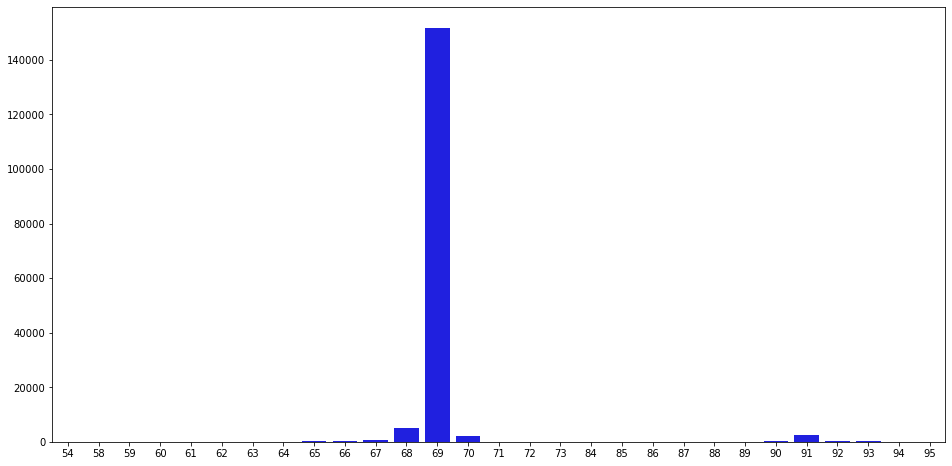

In [63]:
# Raw sequence lengths
fig, ax = plt.subplots(figsize=(16,8))
plt_data = otx_data['Enhancer'].apply(len).value_counts().astype(object) 
plt_data = plt_data[plt_data >= 10]
sns.barplot(x=plt_data.index, y=plt_data.values, color='blue', ax=ax);

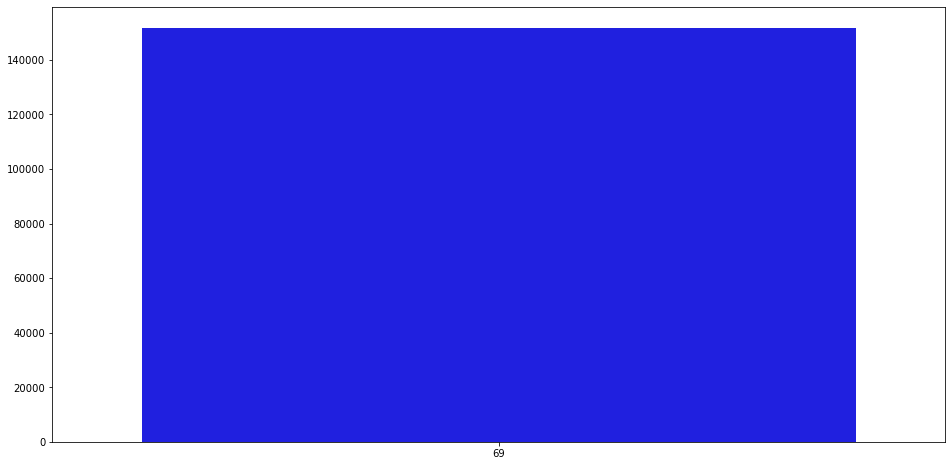

In [64]:
# Filtered sequence lengths
fig, ax = plt.subplots(figsize=(16,8))
plt_subset = otx_subset['Enhancer'].apply(len).value_counts().astype(object) 
plt_subset = plt_subset[plt_subset >= 10]
sns.barplot(x=plt_subset.index, y=plt_subset.values, color='blue', ax=ax);

## Biological replicate concordance

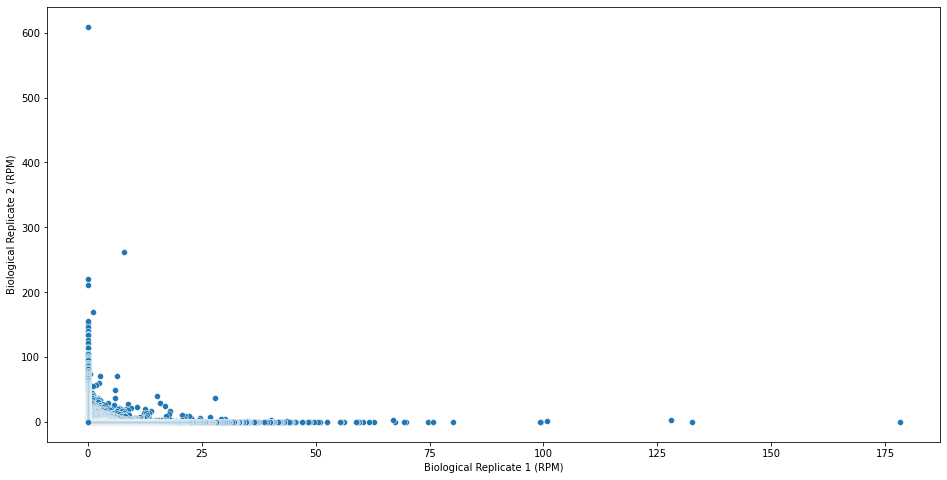

In [65]:
fig, ax = plt.subplots(figsize=(16,8))
sns.scatterplot(data=otx_data, x='Biological Replicate 1 (RPM)', y='Biological Replicate 2 (RPM)', ax=ax);

In [66]:
from scipy.stats import pearsonr

In [67]:
pearsonr(otx_data['Biological Replicate 1 (RPM)'], otx_data['Biological Replicate 2 (RPM)'])

(-0.08841874219990353, 2.2070501903626192e-281)

## Frequencies of nucleotides at each position
TODO: Use a package like logomaker to visualize this better

In [68]:
def freq_lists(dna_list):
    n = len(dna_list[0])
    A = [0]*n
    T = [0]*n
    G = [0]*n
    C = [0]*n
    N = [0]*n
    for dna in dna_list:
        for index, base in enumerate(dna):
            if base == 'A':
                A[index] += 1
            elif base == 'C':
                C[index] += 1
            elif base == 'G':
                G[index] += 1
            elif base == 'T':
                T[index] += 1
            else:
                N[index] += 1
    return A, C, G, T, N

In [69]:
pos_counts = pd.DataFrame(freq_lists(seqs))

In [70]:
pos_freqs = pos_counts/(pos_counts.sum(axis=0))

In [71]:
pos_freqs.index = pd.Index(['A', 'C', 'G', 'T', 'N'])
pos_freqs.columns = range(1, len(X[0])+1)

In [72]:
def move_legend(ax, new_loc, **kws):
    old_legend = ax.legend_
    handles = old_legend.legendHandles
    labels = [t.get_text() for t in old_legend.get_texts()]
    title = old_legend.get_title().get_text()
    ax.legend(handles, labels, loc=new_loc, title=title, **kws)

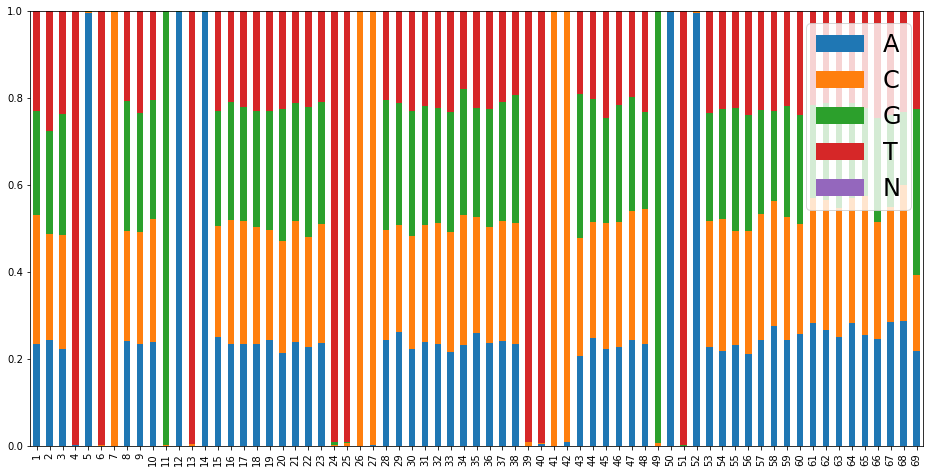

In [73]:
fig, ax = plt.subplots(figsize=(16, 8))
ax.set_ylim(0, 1)
pos_freqs.T.plot(kind='bar', stacked=True, ax=ax)
move_legend(ax, 1, fontsize=24)

GATA GATA ETS ETS GATA

In [74]:
# Example sequence
np.set_printoptions(threshold=40)
print("Example sequence\n-----------------------")
print('DNA Sequence #1:\n', X[0][:10],'...', X[0][-10:])
print('One hot encoding of Sequence #1:\n',input_features[0])

Example sequence
-----------------------
DNA Sequence #1:
 GGATATCACA ... CTGTCACCAG
One hot encoding of Sequence #1:
 [[0. 0. 1. ... 0. 1. 0.]
 [0. 0. 0. ... 1. 0. 0.]
 [1. 1. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 0.]]


## Target RPM distribution

Text(0.5, 0, 'Average RPM')

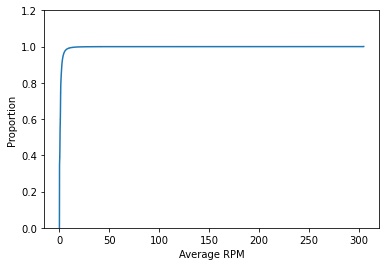

In [75]:
# Check distributions of average RPMs
ax = sns.ecdfplot(otx_data[['Biological Replicate 1 (RPM)', 'Biological Replicate 2 (RPM)']].mean(axis=1).values)
ax.set_ylim(0, 1.2)
ax.set_xlabel('Average RPM')

Text(0.5, 0, 'Max RPM')

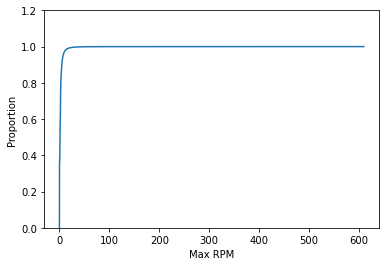

In [76]:
# Check distributions of average RPMs
ax = sns.ecdfplot(otx_data[['Biological Replicate 1 (RPM)', 'Biological Replicate 2 (RPM)']].max(axis=1).values)
ax.set_ylim(0, 1.2)
ax.set_xlabel('Max RPM')

# Build model
Currently build like original DeepSEA
TODOS: 
1. Add weight normalization
2. Simpler model?

In [26]:
import torch.nn as nn
import torch.nn.functional as F
import torch

class EUGENE(nn.Module):
    def __init__(self):
        super(EUGENE, self).__init__()
        self.Conv1 = nn.Conv1d(in_channels=4, out_channels=320, kernel_size=8)
        self.Conv2 = nn.Conv1d(in_channels=320, out_channels=480, kernel_size=8)
        self.Maxpool = nn.MaxPool1d(kernel_size=4, stride=4)
        self.Drop1 = nn.Dropout(p=0.2)
        self.Drop2 = nn.Dropout(p=0.5)
        self.Linear1 = nn.Linear(960, 925)
        self.Linear2 = nn.Linear(925, 1)


    def forward(self, input):
        x = self.Conv1(input)
        x = F.relu(x)
        x = self.Maxpool(x)
        x = self.Drop1(x)
        x = self.Conv2(x)
        x = F.relu(x)
        x = self.Maxpool(x)
        x = self.Drop1(x)
        x = x.view(-1, 960)
        x = self.Linear1(x)
        x = F.relu(x)
        x = self.Linear2(x)
        return x

In [27]:
# Instantiate model and move to gpu if available
eugene = EUGENE()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Executing the model on :", device)
eugene.to(device)

Executing the model on : cuda


EUGENE(
  (Conv1): Conv1d(4, 320, kernel_size=(8,), stride=(1,))
  (Conv2): Conv1d(320, 480, kernel_size=(8,), stride=(1,))
  (Maxpool): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (Drop1): Dropout(p=0.2, inplace=False)
  (Drop2): Dropout(p=0.5, inplace=False)
  (Linear1): Linear(in_features=960, out_features=925, bias=True)
  (Linear2): Linear(in_features=925, out_features=1, bias=True)
)

# Train model

## Split data into train, val and test sets
- Currently split all data 90:10 into train and test
- Then split train into train and val 70:30
- TODO:
    1. Do I need to be more careful in splitting instead of randomly doing so?
    2. Why is MAE so much higher than MSE

In [28]:
from sklearn.model_selection import train_test_split

In [29]:
# Split first into train and test, then split train into train and val
train_data, test_data, train_targets, test_targets = train_test_split(input_features, y, test_size=0.1, random_state=13)
train_data, val_data, train_targets, val_targets = train_test_split(train_data, train_targets, test_size=0.3, random_state=13)

In [30]:
# Output sizes
print("Size of training set: {} samples".format(train_data.shape[0]))
print("Size of validation set: {} samples".format(val_data.shape[0]))
print("Size of test set: {} samples".format(test_data.shape[0]))

Size of training set: 103135 samples
Size of validation set: 44202 samples
Size of test set: 16371 samples


In [31]:
# Boolean to subset if testing
testing = False
if testing:
    train_data = train_data[:1000]
    train_targets = train_targets[:1000]
    val_data = val_data[:100]
    val_targets = val_targets[:100]

In [34]:
from torch.utils.data import TensorDataset, DataLoader

In [35]:
# Build Datasets objects from arrays
train_dataset = TensorDataset(torch.from_numpy(train_data), torch.from_numpy(train_targets))
val_dataset = TensorDataset(torch.from_numpy(val_data), torch.from_numpy(val_targets))

In [36]:
# Build Loaders from the Datasets
train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=256)

In [37]:
# Check dims of loaders for correctness
print("Dimensions of training set: {} x {}".format(len(train_loader.dataset), train_loader.dataset[0][0].shape))
print("Dimensions of validation set: {} x {}".format(len(val_loader.dataset), val_loader.dataset[0][0].shape))

Dimensions of training set: 103135 x torch.Size([4, 69])
Dimensions of validation set: 44202 x torch.Size([4, 69])


In [38]:
from livelossplot import PlotLosses

In [39]:
# Current livelossplot compatible training script
def train_model(model, criterion, optimizer, num_epoch):
    liveloss = PlotLosses()
    loss_history, mae_history = {}, {}
    for epoch in range(num_epoch):
        logs = {}
        for phase in ['train', 'validation']:
            if phase == 'train':
                model.train()
            else:
                model.eval()
            
            running_loss = 0.0
            running_mae = 0.0
            for inputs, targets in dataloaders[phase]:
                inputs = inputs.to(device)
                outputs = model(inputs.float())
                targets = targets.unsqueeze(dim=1).to(device)
                loss = criterion(outputs, targets.unsqueeze(dim=1).float())
                if phase == 'train':
                    optimizer.zero_grad()
                    loss.backward()                
                    optimizer.step()            
                
                running_loss += loss.item()
                running_mae += (outputs - targets).abs().sum().item()
            
            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_mae = running_mae / len(dataloaders[phase].dataset)
                
            prefix = ''
            if phase == 'validation':
                prefix = 'val_'

            logs[prefix + 'loss'] = epoch_loss
            logs[prefix + 'mae'] = epoch_mae
            
            loss_history.setdefault(phase, []).append(epoch_loss)
            mae_history.setdefault(phase, []).append(epoch_mae)
            
        liveloss.update(logs)
        liveloss.send()
    return loss_history, mae_history, liveloss

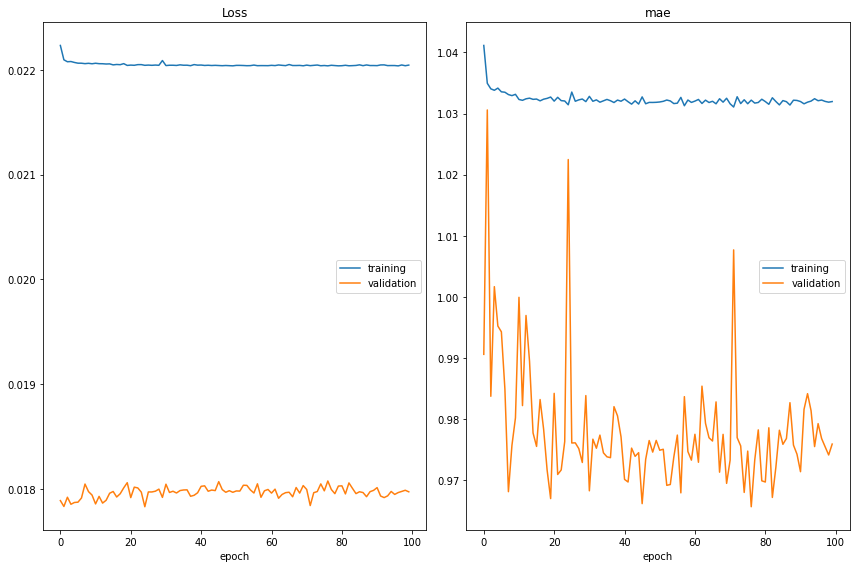

Loss
	training         	 (min:    0.022, max:    0.022, cur:    0.022)
	validation       	 (min:    0.018, max:    0.018, cur:    0.018)
mae
	training         	 (min:    1.031, max:    1.041, cur:    1.032)
	validation       	 (min:    0.966, max:    1.031, cur:    0.976)


In [40]:
# Train the model
dataloaders = {"train": train_loader, "validation": val_loader}
optimizer = torch.optim.RMSprop(eugene.parameters(), lr=0.0001)
criterion = torch.nn.MSELoss()
loss_history, mae_history, _ = train_model(eugene, criterion, optimizer, 100)

# Evaluate model

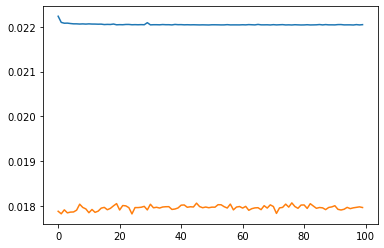

In [58]:
plt.plot(loss_history['train'])
plt.plot(loss_history['validation'])

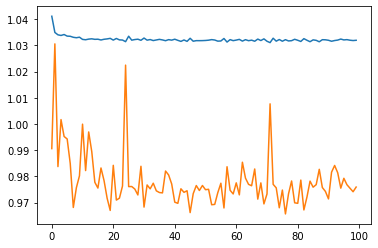

In [59]:
plt.plot(mae_history['train'])
plt.plot(mae_history['validation'])

In [41]:
eugene.to('cpu')

EUGENE(
  (Conv1): Conv1d(4, 320, kernel_size=(8,), stride=(1,))
  (Conv2): Conv1d(320, 480, kernel_size=(8,), stride=(1,))
  (Maxpool): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (Drop1): Dropout(p=0.2, inplace=False)
  (Drop2): Dropout(p=0.5, inplace=False)
  (Linear1): Linear(in_features=960, out_features=925, bias=True)
  (Linear2): Linear(in_features=925, out_features=1, bias=True)
)

In [42]:
outputs = eugene(torch.from_numpy(test_data).float())

/cellar/users/aklie/opt/miniconda3/envs/ml_env/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


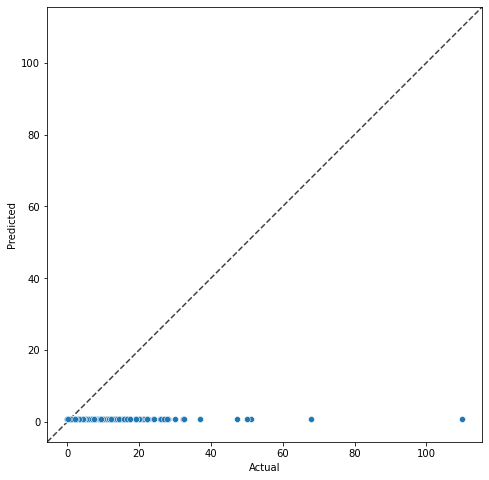

In [55]:
fig, ax = plt.subplots(figsize=(16, 8))
sns.scatterplot(test_targets, outputs.squeeze(dim=1).detach(), ax=ax)
lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]

# now plot both limits against eachother
ax.plot(lims, lims, 'k--', alpha=0.75, zorder=0)
ax.set_aspect('equal')
ax.set_xlim(lims)
ax.set_ylim(lims)
ax.set_xlabel('Actual')
ax.set_ylabel('Predicted');

In [48]:
from scipy.stats import pearsonr

In [45]:
pearsonr(test_targets, outputs.squeeze(dim=1).detach())

(0.010441264958219988, 0.18158654075188374)

# Model interpretation

# References
1. Farley, E. K. et al. Suboptimization of developmental enhancers. Science 350, 325–328 (2015)